(784,)


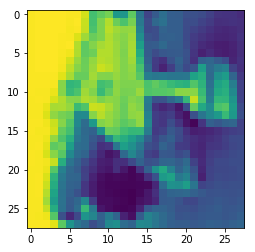

In [18]:
import scipy.io
mat = scipy.io.loadmat('data/objects-train.mat')

import matplotlib.pyplot as plt
import numpy as np
x = np.array(mat['images_train'][:,0])
print(x.shape)
plt.imshow(x.reshape(28,28))
plt.show()

In [2]:
feat = mat['fea_hog_train']

In [31]:
from sklearn.metrics.cluster import supervised
from scipy.optimize import linear_sum_assignment

def accuracy(labels_true, labels_pred):
    labels_true, labels_pred = supervised.check_clusterings(labels_true, labels_pred)
    # labels_true : int array with ground truth labels, shape = [n_samples]
    # labels_pred : int array with estimated labels, shape = [n_samples]
    value = supervised.contingency_matrix(labels_true, labels_pred)
    # value : array of shape [n, n] whose (i, j)-th entry is the number of samples in true class i and in predicted class j
    [r, c] = linear_sum_assignment(-value)
    return value[r, c].sum() / len(labels_true)

In [4]:
accuracy([2]*10,[1]*10)

1.0

In [5]:
np.reshape(mat['labels_train'],-1).shape

(5000,)

In [6]:
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import numpy as np

kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=0).fit_predict(np.transpose(feat))
accuracy(kmeans, np.reshape(mat['labels_train'],-1))

0.3608

In [7]:

kmeans = sklearn.cluster.SpectralClustering(n_clusters=5).fit_predict(np.transpose(feat))
accuracy(kmeans, np.reshape(mat['labels_train'],-1))

0.2454

In [8]:

kmeans = sklearn.cluster.Birch(n_clusters=5).fit_predict(np.transpose(feat))
accuracy(kmeans, np.reshape(mat['labels_train'],-1))

0.419

In [9]:
# import sklearn.mixture
# for g in ['full', 'tied', 'diag', 'spherical']:
#     accs = []
#     for _ in range(5):
#         gmm = sklearn.mixture.GaussianMixture(n_components=5, covariance_type=g, max_iter=100).fit(np.transpose(feat))
#         kmeans = gmm.predict(np.transpose(feat))
#         accs.append(accuracy(kmeans, np.reshape(mat['labels_train'],-1)))
#     print(g, ': ', np.mean(accs), '+/-', np.std(accs))

In [10]:
import tensorflow

C:\Users\Mason Cole\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K

from resnet_keras import resnet152_model

weights_path = 'resnet_data/resnet152_weights_tf.h5'

model = resnet152_model(weights_path)
sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


layer_name = 'res5a_relu'

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


Using TensorFlow backend.


In [12]:
# perm = np.random.permutation(5000)[:50]
x = np.reshape(np.transpose(np.repeat(mat['images_train'][:,:, np.newaxis],3, axis=2), (1, 0, 2)), (-1, 28, 28, 3))

large_images = np.array([scipy.misc.imresize(scipy.misc.imrotate(image, -90), size=(224,224), interp='bilinear') for image in x])

intermediate_output = intermediate_layer_model.predict(large_images)
print(intermediate_output.shape)

C:\Users\Mason Cole\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  after removing the cwd from sys.path.
C:\Users\Mason Cole\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


(5000, 7, 7, 2048)


In [13]:
intermediate_output.shape

(5000, 7, 7, 2048)

In [15]:
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import numpy as np

kmeans = sklearn.cluster.Birch(n_clusters=5).fit_predict(np.squeeze(np.mean(intermediate_output, (1,2))))
accuracy(kmeans, np.reshape(mat['labels_train'],-1))

0.5622

In [ ]:
import scipy.misc

print(x[0])

y = np.array([scipy.misc.imresize(image, size=(224,224)) for image in x[:]])
print(y.shape)

In [19]:
np.savetxt('digits.csv', kmeans + 1, fmt='%i', delimiter=',')

In [35]:
import scipy.io
mat = scipy.io.loadmat('data/digits-test.mat')

import matplotlib.pyplot as plt
import numpy as np

# x = np.array(mat['images_test'])
# print(x)

feat = mat['fea_hog_test']

kmeans = sklearn.cluster.Birch(n_clusters=5, threshold=0.7).fit_predict(np.transpose(feat))
# accuracy(kmeans, np.reshape(mat['labels_train'],-1))

np.savetxt('digits.csv', kmeans + 1, fmt='%i', delimiter=',', newline='\n')


# import matplotlib.pyplot as plt
# plt.imshow(np.reshape(x[:,0], (28,28)))
# plt.show()
# plt.imshow(np.reshape(x[:,3], (28,28)))
# plt.show()